In [139]:
import sys
!{sys.executable} -m pip install pytorch-gradcam
#!{sys.executable} -m pip install torch==2.0.0 torchvision==0.15.1 torchaudio==2.0.1




     |████████████████████████████████| 6.0 MB 1.3 MB/s eta 0:00:01
  Created wheel for pytorch-gradcam: filename=pytorch_gradcam-0.2.1-py3-none-any.whl size=5269 sha256=d5081fcb593335bdf35adda2b994152ab0133c2d9a6e93de0cd40da1368abebe
  Stored in directory: /home/tyler/.cache/pip/wheels/4e/56/d5/03e24169efc67e14aa5502c53d3030bc3b05ec32fde773b405
Successfully built pytorch-gradcam


In [1]:
import pandas as pd
import pickle as pkl
import numpy as np
from tqdm import tqdm
import os
import sys
from os import path
import pickle as pkl
import matplotlib.pyplot as plt
import datetime
import json
import cv2
# import utils
import time
import ssl
from PIL import Image
from skimage import io 

from sklearn.metrics.pairwise import cosine_similarity as cos_sim
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, pairwise_distances, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score, roc_curve, RocCurveDisplay

# import nibabel as nib
# PyTorch libraries and modules
import torch
from torch.utils.data import Dataset, DataLoader, random_split, WeightedRandomSampler
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.models import ResNet50_Weights
from torchvision.utils import save_image
from torchvision.utils import make_grid
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import *
from sklearn.model_selection import train_test_split
#import torch.optim.lr_scheduler as lr_scheduler
#from torchmetrics.classification import BinaryAUROC 

import matplotlib.pyplot as plt
import matplotlib

In [2]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()
    def __str__(self):
        return f' is {self.avg}'
    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0
    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [3]:
#hyperparameters 

do_train=True
n_iters = 75
#age_lower = 20
#age_upper = 100
disp_labels = ['Good', 'Bad'] # My classifiers are just yes/no 
print_every = 1
plot_every = 1
batch_size = 16
model_name = 'densenet121-finetuned' # Can test out different pretrained models 
save_dir = 'Models/' 
metric_name = 'accuracy' # For me it would be different -- i put accuracy but we will see if that is an option
predictor = 'middle_sagittal' # Whether the image is good or not 
lr = 0.0001
maximize_metric=True
patience = 5
early_stop=False
prev_val_loss = 1e10
itr = 0
best_model_dir = None#'/media/Datacenter_storage/BiologicalAge/Code/Models/train/train-23/'
header_data = '/media/Datacenter_storage/Kowa_Images_rgb/sample_1000/' #Kowa_Images_rgb/sample_1000.csv
csv_header = '/home/tyler/Fundus_View_Classifier'
# Remember to use absolute paths! 

In [4]:
# Change this to my own type of dataset 

class FundusDataset(Dataset):
    def __init__(self, df, mode = None):
        self.df = df
        self.mode = mode 
        
        self.augmentations = ([
            transforms.ToPILImage(),
            transforms.Resize((256, 256)),
            transforms.CenterCrop((256, 256)),
            #transforms.RandomRotation(degrees=(0, 15)),
            transforms.RandomHorizontalFlip(p = 0.5),
            transforms.RandomVerticalFlip(p = 0.5),
            transforms.ToTensor(),
        ])
        self.transform = transforms.Compose([
                                    transforms.ToPILImage(),
                                    transforms.Resize((256, 256)),
                                    transforms.CenterCrop((256, 256)),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.47, 0.47, 0.47], [0.3033, 0.3033, 0.3033])
                                    ])

    def __len__(self):
        return len(self.df)
  

    def __getitem__(self, index):
        label = self.df.at[index, 'LABEL']
        
        img_loc = self.df.at[index, 'key'] 
        
        try:
            img = io.imread(os.path.join(header_data, img_loc))
            
            img = ( ((img - np.min(img)) / (np.max(img) - np.min(img)))   * 255.0)
            
            img = img.astype(np.uint8)
            
            if self.mode == 'train':
                for aug in self.augmentations:
                    img = aug(img)
            img = self.transform(img)
            #else:
               # img = self.transform(img)
            return  img , label 
            
        except Exception as e: 
            print(f'Error loading image {img_loc}: {e}')
            return None

In [5]:
df = pd.read_csv(os.path.join(csv_header + '/good_sample_1000.csv'))


In [6]:
with open('/home/tyler/Fundus_View_Classifier/fundus_data_new.pkl', 'rb') as fp:
    fundus_data = pkl.load(fp)
df_train = fundus_data['train'].reset_index()
df_test = fundus_data['test'].reset_index()
df_val = fundus_data['val'].reset_index()

df_test['LABEL'][df_test['LABEL'] == True].count()

70

In [10]:
classes = (True, False)

In [11]:
model = models.densenet201(pretrained = False)
print(model)
model.classifier = nn.Sequential(
    nn.Dropout(0.6),
    nn.Linear(model.classifier.in_features, 1)
)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [12]:
datagen_train = FundusDataset(df =  df_train.copy(), mode = 'train') 
datagen_val = FundusDataset(df = df_val.copy(), mode = 'val') 
datagen_test = FundusDataset(df = df_test.copy(), mode = 'test') 

In [13]:
class_weights = {True: 2.75, False: 1.0}
train_weights = [class_weights[e] for e in df_train["LABEL"]]


sampler = WeightedRandomSampler(train_weights, num_samples = len(df_train))


In [14]:
train_loader = DataLoader(dataset=datagen_train,  batch_size=batch_size, num_workers=2, sampler = sampler )
val_loader = DataLoader(dataset=datagen_val,  shuffle=False, batch_size=batch_size, num_workers=2)
test_loader = DataLoader(dataset=datagen_test,  shuffle=False, batch_size=batch_size, num_workers=2)



In [15]:
#weights = torch.tensor(5)

In [16]:
cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(cuda, device)
sys.stdout.flush()
criterion = torch.nn.BCEWithLogitsLoss().to(device)   #BCEWithLogitsLoss().to(device)
#pos_weight = torch.from_numpy(np.array([3, 1])
optimizer = torch.optim.Adam(model.parameters(),lr=lr)
#scheduler = lr_scheduler.ExponentialLR(optimizer, gamma = 0.5)

True cuda:0


In [17]:
current_loss = 0
min_valid_loss = np.inf
all_losses = []
best_model = None 

In [18]:
torch.cuda.empty_cache()
if cuda:
    model = model.to(device)
    model.train()



# Did you change the model path? And mark what you did differently this model? 

In [17]:
df_loss = pd.DataFrame(columns = ['train', 'val', 'train_auroc', 'val_auroc'])
prev_val_acc = 0
patience_val = 0 
min_val_acc = np.inf 
print('start')
sys.stdout.flush()
for epoch in range(n_iters):
    
    y_pred = []
    y_true = []
    y_prob= None
    
    losses = AverageMeter()
    valid_losses = AverageMeter()
    
    
    model.train()
    
    for inputs, labels in tqdm(train_loader):
        # get the inputs; data is a list of [inputs, labels]
        model.train()
        labels = labels.type(torch.LongTensor)
        inputs, labels = inputs, labels = Variable(inputs, requires_grad = True).to(device), Variable(labels, requires_grad = False).to(device)
        
        labels = labels.unsqueeze(1)
        labels = labels.float()
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        output = model(inputs)
        sig = nn.Sigmoid()
        probs = sig(output).cpu().detach().numpy()  # (batch_size, )
        if y_prob is None:
            y_prob = probs
        else:
            y_prob = np.concatenate((y_prob, probs), axis=0)
        y_true += list(labels.cpu().detach().numpy().astype(int))
        
        loss = criterion(output, labels)
      
        losses.update(loss.item(), inputs.size(0))
      
        loss.backward()
        optimizer.step()
    
    
     
    print(f'Iteration {epoch}...')
    print(f'Training Loss{str(losses)}')            
    df_loss.at[epoch, 'train'] = losses.avg    
    
    roc_score = roc_auc_score(y_true, y_prob)
    
    model.eval() 
    print(f'Training Auroc: {roc_score}')
    df_loss.at[epoch, 'train_auroc']= roc_score
    
    y_pred = []
    y_true = []
    y_prob= None
    
    with torch.no_grad():
        for inputs, labels in tqdm(val_loader): 
            labels = labels.type(torch.LongTensor)
            inputs, labels = Variable(inputs, requires_grad = True).to(device), Variable(labels, requires_grad = False).to(device)
            labels = labels.unsqueeze(1)
            labels = labels.float()
            
            output = model(inputs)
                
            sig = nn.Sigmoid()
            probs = sig(output).cpu().detach().numpy()
           # y_pred += list(preds)
            
            
                
            if y_prob is None:
                y_prob = probs
            else:
                y_prob = np.concatenate((y_prob, probs), axis=0)
            y_true += list(labels.cpu().detach().numpy().astype(int))
            loss = criterion(output, labels)
            valid_losses.update(loss.item(), inputs.size(0))
            
    
    
    
    print(f'Validation loss{str(valid_losses)}')
    
    df_loss.at[epoch, 'val'] = valid_losses.avg
    roc_score = roc_auc_score(y_true, y_prob)
    print(f'Validation Auroc: {roc_score}')
    df_loss.at[epoch, 'val_auroc']= roc_score
    
    if valid_losses.avg < prev_val_acc: 
        patience_val = 0
    if valid_losses.avg >= prev_val_acc: 
        patience_val += 1 
    if patience_val > patience: 
        break 
    prev_val_acc = valid_losses.avg
    
    if  valid_losses.avg < min_val_acc:
        min_val_acc = valid_losses.avg
        torch.save(model.state_dict(), 'Models/model2/model_2_best.pt')

   
print('Finished Training')
display(df_loss)

start


100%|██████████| 46/46 [00:34<00:00,  1.34it/s]


Iteration 0...
Training Loss is 0.49628885815052387
Training Auroc: 0.805167886169359


100%|██████████| 6/6 [00:04<00:00,  1.28it/s]


Validation loss is 0.5729985687790847
Validation Auroc: 0.8261398176291793


100%|██████████| 46/46 [00:34<00:00,  1.33it/s]


Iteration 1...
Training Loss is 0.38367867762925195
Training Auroc: 0.9018801187123806


100%|██████████| 6/6 [00:04<00:00,  1.30it/s]


Validation loss is 0.45803304707131737
Validation Auroc: 0.9306990881458965


100%|██████████| 46/46 [00:34<00:00,  1.32it/s]


Iteration 2...
Training Loss is 0.26789261897404987
Training Auroc: 0.947101758449395


100%|██████████| 6/6 [00:04<00:00,  1.29it/s]


Validation loss is 0.30051122714833517
Validation Auroc: 0.9641337386018237


100%|██████████| 46/46 [00:34<00:00,  1.32it/s]


Iteration 3...
Training Loss is 0.24139258623774587
Training Auroc: 0.9579992363497518


100%|██████████| 6/6 [00:04<00:00,  1.28it/s]


Validation loss is 0.23726249904167362
Validation Auroc: 0.9872340425531916


100%|██████████| 46/46 [00:34<00:00,  1.32it/s]


Iteration 4...
Training Loss is 0.15221476449015361
Training Auroc: 0.9863300463534985


100%|██████████| 6/6 [00:04<00:00,  1.30it/s]


Validation loss is 0.1592207027644646
Validation Auroc: 0.9896656534954407


100%|██████████| 46/46 [00:34<00:00,  1.33it/s]


Iteration 5...
Training Loss is 0.1298484363353969
Training Auroc: 0.987182087689187


100%|██████████| 6/6 [00:04<00:00,  1.29it/s]


Validation loss is 0.10547716007000063
Validation Auroc: 0.9933130699088146


100%|██████████| 46/46 [00:34<00:00,  1.32it/s]


Iteration 6...
Training Loss is 0.11536963522189954
Training Auroc: 0.9910399899396378


100%|██████████| 6/6 [00:04<00:00,  1.29it/s]


Validation loss is 0.1537372473536468
Validation Auroc: 0.98419452887538


100%|██████████| 46/46 [00:34<00:00,  1.33it/s]


Iteration 7...
Training Loss is 0.08726342952723712
Training Auroc: 0.9958564814814814


100%|██████████| 6/6 [00:04<00:00,  1.28it/s]


Validation loss is 0.13007702333171192
Validation Auroc: 0.9878419452887538


100%|██████████| 46/46 [00:34<00:00,  1.32it/s]


Iteration 8...
Training Loss is 0.10751739366214132
Training Auroc: 0.988874808554969


100%|██████████| 6/6 [00:04<00:00,  1.29it/s]


Validation loss is 0.2114925355446048
Validation Auroc: 0.9787234042553192


100%|██████████| 46/46 [00:34<00:00,  1.32it/s]


Iteration 9...
Training Loss is 0.08050311571546917
Training Auroc: 0.9916336804579796


100%|██████████| 6/6 [00:04<00:00,  1.29it/s]


Validation loss is 0.106814031557339
Validation Auroc: 0.9908814589665653


100%|██████████| 46/46 [00:34<00:00,  1.32it/s]


Iteration 10...
Training Loss is 0.0904327994466968
Training Auroc: 0.993879182368391


100%|██████████| 6/6 [00:04<00:00,  1.29it/s]


Validation loss is 0.13879463440034448
Validation Auroc: 0.990273556231003


100%|██████████| 46/46 [00:34<00:00,  1.32it/s]


Iteration 11...
Training Loss is 0.10584623643446489
Training Auroc: 0.9933523266856601


100%|██████████| 6/6 [00:04<00:00,  1.29it/s]


Validation loss is 0.14330358221763517
Validation Auroc: 0.9781155015197568


100%|██████████| 46/46 [00:34<00:00,  1.32it/s]


Iteration 12...
Training Loss is 0.07240073433746405
Training Auroc: 0.9937314034217704


100%|██████████| 6/6 [00:04<00:00,  1.29it/s]


Validation loss is 0.17052935245560435
Validation Auroc: 0.99209726443769


100%|██████████| 46/46 [00:34<00:00,  1.32it/s]


Iteration 13...
Training Loss is 0.11605687905611888
Training Auroc: 0.9905025937315566


100%|██████████| 6/6 [00:04<00:00,  1.28it/s]


Validation loss is 0.1660320711571996
Validation Auroc: 0.9793313069908813


 83%|████████▎ | 38/46 [00:28<00:06,  1.31it/s]


KeyboardInterrupt: 

In [18]:
df_loss


,train,val,train_auroc,val_auroc
0,0.496289,0.572999,0.805168,0.82614
1,0.383679,0.458033,0.90188,0.930699
2,0.267893,0.300511,0.947102,0.964134
3,0.241393,0.237262,0.957999,0.987234
4,0.152215,0.159221,0.98633,0.989666
5,0.129848,0.105477,0.987182,0.993313
6,0.11537,0.153737,0.99104,0.984195
7,0.0872634,0.130077,0.995856,0.987842
8,0.107517,0.211493,0.988875,0.978723
9,0.0805031,0.106814,0.991634,0.990881


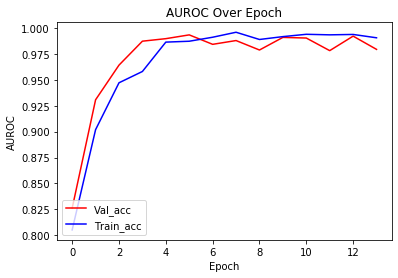

In [19]:
plt.plot(range(0, len(df_loss) ), df_loss['val_auroc'], c = 'red')
plt.plot(range(0, len(df_loss)), df_loss['train_auroc'], c = 'blue')

plt.legend(['Val_acc', 'Train_acc'], loc = 3)
plt.title('AUROC Over Epoch')
plt.ylabel('AUROC')
plt.xlabel('Epoch')
plt.savefig('Models/model2/model2_AUROC.png')
plt.show()


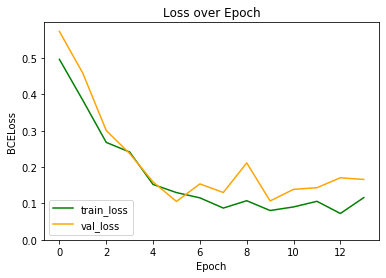

In [20]:
plt.plot(range(len(df_loss)), df_loss['train'], c = 'green')
plt.plot(range(len(df_loss)), df_loss['val'], c = 'orange')
plt.ylim(bottom = 0)
plt.legend([ 'train_loss', 'val_loss'], loc = 3)
plt.title('Loss over Epoch')
plt.ylabel('BCELoss')
plt.xlabel('Epoch')
plt.savefig('Models/model2/model2.BCELoss.png')
plt.show()


# Remember to do test dataset as well 

In [19]:
model = models.densenet201(pretrained = False)
model.classifier = nn.Sequential(
    nn.Dropout(0.6),
    nn.Linear(model.classifier.in_features, 1)
)
model.load_state_dict(torch.load('/home/tyler/Fundus_View_Classifier/model_2_best.pt'))
model.to(device)
model.eval()

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

100%|██████████| 12/12 [00:09<00:00,  1.30it/s]

ROC Score: 0.992487684729064
Loss Score: 0.10125657587602574


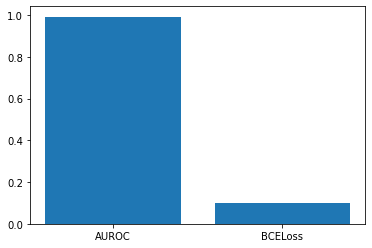

[[112   4]
 [  1  69]]


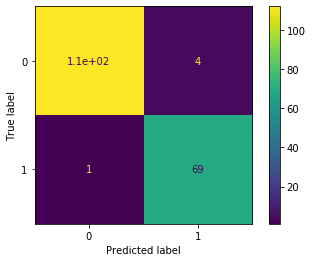

In [20]:
y_pred = []
y_true = []
y_prob= None
test_losses = AverageMeter()


with torch.no_grad():
    for inputs, labels in tqdm(test_loader):
        labels = labels.type(torch.LongTensor)
        inputs, labels = Variable(inputs, requires_grad = True).to(device), Variable(labels, requires_grad = False).to(device)
        labels = labels.unsqueeze(1)
        labels = labels.float()
            
        output = model(inputs)
                
        sig = nn.Sigmoid()
        probs = sig(output).cpu().detach().numpy()
        
        if y_prob is None:
            y_prob = probs
        else:
            y_prob = np.concatenate((y_prob, probs), axis=0)
        
        pred = (torch.from_numpy(probs) > 0.60).float()
        y_pred += pred
        y_true += list(labels.cpu().detach().numpy().astype(int))
        loss = criterion(output, labels)
        test_losses.update(loss.item(), inputs.size(0))

        
roc_score = roc_auc_score(y_true, y_prob)

print(f'ROC Score: {roc_score}')
print(f'Loss Score: {test_losses.avg}')

plt.bar(['AUROC', 'BCELoss'],[roc_score, test_losses.avg])
#plt.savefig(os.path.join('Models/model2', 'stats.png'))
plt.show()


cm = confusion_matrix(y_true, y_pred)
print(cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,  display_labels=np.array(['0', '1']))
disp.plot()
#plt.savefig(os.path.join('Models/model2', "confusion_matrix.png"))

In [21]:
df_true = pd.DataFrame(y_true)
df_true
df_test['LABEL'][54]

False

In [22]:
df_prob = pd.DataFrame(y_prob)

In [23]:
b = df_prob[df_prob[0] > 0.6]
b

,0
3,0.994771
6,0.969775
7,0.993015
9,0.988187
11,0.987629
...,...
177,0.983753
178,0.980089
179,0.956056
181,0.986501


In [24]:
 a= df_true[df_true[0] == 0]

In [25]:
a = (a).dropna()
b = b.dropna()
(a + b).dropna()

,0
73,0.685545
139,0.791488
163,0.982653
166,0.966375


556f268083bee26de8ea45b4d5aa09bc03a75d909973cf4575ab5de2_64850310808f7cf8cc2acaf653353053dd2a9b42a57795139133d186.png


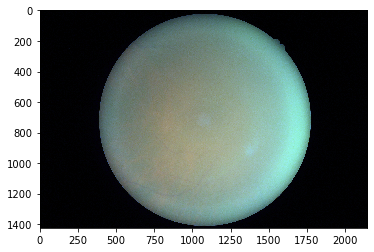

In [26]:
img = io.imread(os.path.join(header_data, df_test['key'][139]))
print(df_test["key"][139])

plt.imshow(img)
#print(df_test['LABEL'][178])

In [27]:
# Me: 3, 6, 14, 22, 26, 29, 30, 44, 47, 54, 72, 73, 86, 96, 99, 102, 103, 113, 120, 122, 123, 145, 156   
# Ami: 26?
# Bhavik: 26?
# Model Wrong: 62, 147, 178 

In [28]:
# Me: 
# Model Wrong: 31, 40, 110, 116, 148, 192 

In [29]:
from gradcam.utils import visualize_cam
from gradcam import GradCAM, GradCAMpp


In [30]:
configs = [
    dict(model_type='densenet', arch=model, layer_name='features_norm5') 
]

In [31]:
for config in configs:
    config['arch'].to(device).eval()

cams = [
    [cls.from_config(**config) for cls in (GradCAM, GradCAMpp)]
    for config in configs
]
cams

[[<gradcam.gradcam.GradCAM at 0x7f72a481c4c0>,

In [32]:
def visualize_cam(mask, img, alpha=1.0):
    """Make heatmap from mask and synthesize GradCAM result image using heatmap and img.
    Args:
        mask (torch.tensor): mask shape of (1, 1, H, W) and each element has value in range [0, 1]
        img (torch.tensor): img shape of (1, 3, H, W) and each pixel value is in range [0, 1]

    Return:
        heatmap (torch.tensor): heatmap img shape of (3, H, W)
        result (torch.tensor): synthesized GradCAM result of same shape with heatmap.
    """
    heatmap = (255 * mask.squeeze()).type(torch.uint8).cpu().numpy()
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_TURBO)
    heatmap = torch.from_numpy(heatmap).permute(2, 0, 1).float().div(255)
    b, g, r = heatmap.split(1)
    heatmap = torch.cat([r, g, b]) * alpha

    result = heatmap+img.cpu()
    result = result.div(result.max()).squeeze()

    return heatmap, result

Probability: 0.7914877533912659
True Label: Invalid Image


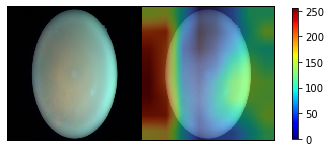

In [43]:
img_tensor = None
i = 139
img, _ = datagen_test.__getitem__(i)
img_tensor = img.unsqueeze(0).to(device)

output = model(img_tensor)

img_loc = df_test.at[i, 'key']

img = Image.open(os.path.join(header_data, img_loc))
img = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])(img).to(device)

images = []
for gradcam, gradcam_pp in cams:
    mask, _ = gradcam(img_tensor)
    heatmap, result = visualize_cam(mask, img)

    mask_pp, _ = gradcam_pp(img_tensor)
    heatmap_pp, result_pp = visualize_cam(mask_pp, img)
    
    images.extend([img.cpu(), result_pp])
    
grid_image = make_grid(images)

values = {0: 'Invalid Image', 1: 'Valid Image'}
y = transforms.ToPILImage()(grid_image)
print(f'Probability: {y_prob[i][0]}')
print(f'True Label: {values[y_true[i][0]]}')
transforms.ToPILImage()(grid_image)
#TP: 6, 7, 9, 177, 178, 179
#TN: 4, 5, 8, 180 
#FP: 73, 139 , 163, 166
'''
for image in images: 
    x = transforms.ToPILImage()(image)
    plt.imshow(x, cmap = 'jet')
    plt.colorbar()
    plt.show()
'''
plt.imshow(y, cmap = 'jet')
plt.colorbar(shrink = 0.6)
plt.grid(False)
plt.axis('off')
#plt.savefig('/home/tyler/Fundus_View_Classifier/Grad-Cam Examples/TN1')
plt.show()

In [115]:
y_prob[177]

array([0.9837531], dtype=float32)

In [65]:
img_tensor = None
 
img, _ = datagen_test.__getitem__(10)
img_tensor = img.unsqueeze(0).to(device)

output = model(img_tensor)
img

tensor([[[-1.5496, -1.5496, -1.5367,  ..., -1.5496, -1.5496, -1.5367],
         [-1.5367, -1.5367, -1.5496,  ..., -1.5496, -1.5496, -1.5496],
         [-1.5367, -1.5367, -1.5496,  ..., -1.5496, -1.5496, -1.5367],
         ...,
         [-1.5367, -1.5367, -1.5367,  ..., -1.5367, -1.5496, -1.5367],
         [-1.5367, -1.5367, -1.5367,  ..., -1.5496, -1.5496, -1.5496],
         [-1.5367, -1.5367, -1.5367,  ..., -1.5496, -1.5367, -1.5367]],

        [[-1.5496, -1.5496, -1.5496,  ..., -1.5496, -1.5496, -1.5496],
         [-1.5496, -1.5496, -1.5496,  ..., -1.5496, -1.5496, -1.5496],
         [-1.5496, -1.5496, -1.5496,  ..., -1.5496, -1.5496, -1.5496],
         ...,
         [-1.5496, -1.5496, -1.5496,  ..., -1.5496, -1.5496, -1.5496],
         [-1.5496, -1.5496, -1.5496,  ..., -1.5496, -1.5496, -1.5496],
         [-1.5496, -1.5496, -1.5496,  ..., -1.5496, -1.5496, -1.5496]],

        [[-1.5367, -1.5367, -1.5367,  ..., -1.5496, -1.5496, -1.5367],
         [-1.5367, -1.5367, -1.5367,  ..., -1

In [66]:
img_loc = df_test.at[10, 'key']

img = Image.open(os.path.join(header_data, img_loc))
print(img)
img = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])(img).to(device)
print(img.shape)

img = img.reshape(256, 256, 3).cpu().numpy()
img.shape

<PIL.PngImagePlugin.PngImageFile image mode=RGB size=2144x1424 at 0x7F69F8A96490>
torch.Size([3, 256, 256])


(256, 256, 3)

In [62]:
images = []
for gradcam, gradcam_pp in cams:
    mask, _ = gradcam(img_tensor)
    heatmap, result = visualize_cam(mask, img)

    mask_pp, _ = gradcam_pp(img_tensor)
    heatmap_pp, result_pp = visualize_cam(mask_pp, img)
    
    images.extend([img.cpu(), heatmap, heatmap_pp, result, result_pp])
    
grid_image = make_grid(images)


AttributeError: 'numpy.ndarray' object has no attribute 'cpu'

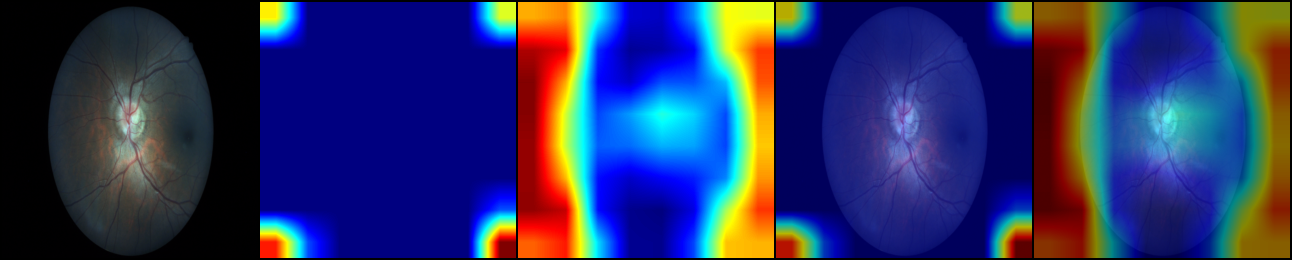

In [34]:
transforms.ToPILImage()(grid_image)


In [35]:
grayscale_cam = cam(input_tensor=img_tensor)

# In this example grayscale_cam has only one image in the batch:
grayscale_cam = torch.from_numpy(grayscale_cam[0, :])
grayscale_cam.shape

NameError: name 'cam' is not defined

In [ ]:
y_prob[11]

In [73]:
fpr, tpr, thresholds = roc_curve(y_true, y_prob)


Text(0.5, 1.0, 'Fundus View Classifier ROC Curve')

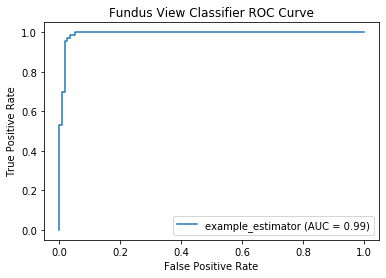

In [74]:
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc = 0.99, estimator_name = 'example_estimator')
display.plot()
plt.title('Fundus View Classifier ROC Curve')

In [280]:
thresholds

array([1.9950320e+00, 9.9503195e-01, 9.8338473e-01, 9.8265344e-01,
       9.6642894e-01, 9.6637517e-01, 8.4003758e-01, 7.9148775e-01,
       7.0740330e-01, 6.8554485e-01, 6.0315710e-01, 4.5701665e-01,
       3.4342322e-01, 1.8552161e-04], dtype=float32)

(256, 256, 3)

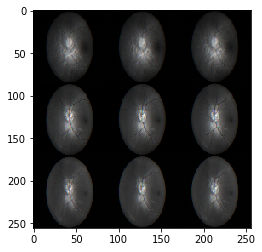

In [75]:
plt.imshow(img, cmap = 'hot')
img.shape